# Read in JSON file of the interview times/speech/speakers information. Parse it and split it into a text file with the times for each speaker. Then break up the video and audio into parts by speaker.

In [3]:
# for extraction from json file
import json
import datetime
import time as ptime 

import pandas as pd

# Import everything needed to edit video clips
# needs to be moviepy 1.0.0 - won't work with newer versions (use pip install movepy==1.0.0)
from moviepy.editor import *


In [6]:
'''
This function extracts the startime and speaker from the given json file and save in a txt file filename_times.txt. 
Also output the video that this json refers to.
'''
def read_output(filename):
        
    filename = (filename).split('.')[0]
  
    # Create an output txt file
    #print(filename+'.txt')
    with open(filename+'_times.txt','w') as w:
        with open(filename+'.json') as f:
            data=json.loads(f.read())
            
            labels = data['results']['speaker_labels']['segments']
            speaker_start_times={}
  
        for label in labels:
            for item in label['items']:
                  speaker_start_times[item['start_time']] = item['speaker_label']
        items = data['results']['items']
        lines = []
        line = ''
        time = 0
        speaker = 'null'
        i = 0
      
                # loop through all elements
        for item in items:
            i = i+1
            content = item['alternatives'][0]['content']
              # if it's starting time
            if item.get('start_time'):
                current_speaker = speaker_start_times[item['start_time']]
              # in AWS output, there are types as punctuation
            elif item['type'] == 'punctuation':
                line = line + content
  
          # handle different speaker
            if current_speaker != speaker:
                if speaker:
                  lines.append({'speaker':speaker, 'line':line, 'time':time})
                line = content
                speaker = current_speaker
                time = item['start_time']
            elif item['type'] != 'punctuation':
                line = line + ' ' + content
        lines.append({'speaker': speaker, 'line': line,'time': time})       
         # sort the results by the time
        sorted_lines = sorted(lines,key=lambda k: float(k['time']))
        
        # write into the .txt file
        for line_data in sorted_lines:
        
            # rather than convert to hh:mi:ss as above does just write the number of seconds
            line = str(line_data['time']) + ' ' + line_data.get('speaker')
            w.write(line + '\n')
        
        #print the interview the given json file relates to
    
    interview_mp4 = data['jobName']
    print('\nThe given json file is associated with the following interview: ' + interview_mp4)
    return interview_mp4

In [36]:
# need to specify path 
read_output("/home/chris/reesby/python/test_interviews/interview_1/asrOutput (2).json")


The given json file is associated with the following interview: V1


'V1'

# Now to extract information from the txt file generated.

In [8]:
#path, file = os.path.split(filename)
#print('path:',path,'file:',file)

# path to file and actual filename

path = "/home/chris/reesby/python/test_interviews/interview_1/"
file = "asrOutput (2).json"

# extract the name of interview video (and output it)
interview_mp4 = read_output(path+file)  #"test_interviews/interview_3/asrOutput (4).json")
print('\nThe interview file you should be using is : ' +interview_mp4+'.mp4')

# make result directory with the label of the interview file
print("\nResults to be stored in newly created "+interview_mp4+ " directory")
if not os.path.isdir(interview_mp4):
    os.mkdir(interview_mp4)


The given json file is associated with the following interview: V1

The interview file you should be using is : V1.mp4

Results to be stored in newly created V1 directory


In [37]:
df = pd.read_csv(path+'asrOutput (2)_times.txt',delimiter=' ', header=None, names=['start_time','speaker'])
df.head()

,start_time,speaker
0,0.00,NaN
1,23.64,spk_1
2,24.29,spk_0
3,26.97,spk_1
4,28.14,spk_0


In [384]:
# how many entries in the data frame
len(df)

43

In [385]:
# add an end time column and set all values to 0
df['end_time']=0.0

In [386]:
# the end time is then simply the start time of the next speaker (until the last time)
for i in range(len(df)-1):
    df['end_time'][i] = df['start_time'][i+1] 


In [387]:
# make last end time 60 seconds long to cover if the video goes that long
# the duration of each video extracted and then this number is corrected depending of the actual length of each video.
df['end_time'].iloc[-1] = df['start_time'].iloc[-1] + 60

In [388]:
# the duration is simply the end time - the start time
df['duration'] = df['end_time'] - df['start_time']

In [46]:
'''
Given the text file decoding of the json file this function then creates a dataframe of start and end times and well as the duration
N.B. the final end time is calculated to using the clip.duation feature of the moviepy library
'''

def create_df(filename):
    path, file = os.path.split(filename)
    print('path:',path,'file:',file)
    # read in the decoded file and assign data to 2 columns - star_time and speaker
    df = pd.read_csv(filename,delimiter=' ', header=None, names=['start_time','speaker'])
    
    # replace the '_times' from the json file
    file_name = filename.replace('_times','') 
    # need to get interview mp4 name to check length of video
    interview_mp4 = read_output(file_name)
    
    
    
    # load the video
    clip = VideoFileClip(path+'/'+interview_mp4+'.mp4') 
    
    # length of video 
    length_of_video = clip.duration    
    #print('length of video is', length_of_video)
    
    # add an end time and duration column and set all values to 0
    df['end_time']=0.0
    df['duration']=0.0
    
    # the end time is then simply the start time of the next speaker (until the last time)
    for i in range(len(df)-1):
        df['end_time'][i] = df['start_time'][i+1] 
    # set the last end time equal to the duration
    df['end_time'].iloc[[-1]] = length_of_video    
    
    # calculate the durations as simply the end - start times.
    for i in range (len(df)):
        df['duration'][i] = df['end_time'][i] - df['start_time'][i]
    
    return df
    

In [48]:
df = create_df('/home/chris/reesby/python/test_interviews/interview_1/asrOutput (2)_times.txt')

path: /home/chris/reesby/python/test_interviews/interview_1 file: asrOutput (2)_times.txt

The given json file is associated with the following interview: V1


In [514]:
df.tail()

,start_time,speaker,end_time,duration
38,585.30,spk_0,617.44,32.14
39,617.44,spk_1,622.24,4.80
40,622.24,spk_0,642.04,19.80
41,642.04,spk_1,643.53,1.49
42,643.53,spk_0,645.96,2.43


In [73]:
df.loc[df['duration']>5]  #=='spk_1']

,start_time,speaker,end_time,duration
1,3.04,spk_0,14.66,11.62
3,16.99,spk_0,29.04,12.05
5,30.44,spk_0,91.04,60.60
6,91.04,spk_1,211.22,120.18
7,211.22,spk_0,224.55,13.33
8,224.55,spk_1,253.44,28.89
10,258.27,spk_1,338.64,80.37
11,338.64,spk_0,344.24,5.60
13,345.69,spk_2,360.41,14.72
16,365.41,spk_1,404.69,39.28


# Now lets try extracting audio/video from the interview video based on the times in the file


In [515]:
'''
This function is given an interview in mp4 format and then based on times given in a dataframe (df)
for each speaker splits the file into smaller video/audio for each speaker

uses moviepy 1.0.0 - this is important it won't work with newer versions of movepy
pip install moviepy==1.0.0
'''

def audio_video_splitter(path, filename, df):
    
    # load the video
    clip = VideoFileClip(path+filename) 
    
    # length of video 
    length_of_video = clip.duration    
    #print('length of video is', length_of_video)
    
    j,k,l =0,0,0 # basic counters for the filenames

    for i in range (len(df)):
    
        speaker = df['speaker'][i] # get the speaker 
        
        # make the final end time equal  the length of the video to stop any errors and correct the final duration time
        #if(df['end_time'][i]> length_of_video):
        #    df['end_time'][i] = length_of_video
        #    df['duration'][i] = df['end_time'][i] - df['start_time'][i]
        
        # checks the duration is longer than 5s before splitting into files (if less than 5s not worth getting emotions from)
        if(df['duration'][i]>5):
            # check the speakers - either speaker 0,1,2 then store the video and audio separately 
            # as spk_0_, spk_1_  or spk_2_ .mp3 for audio and mp4 for video
            if(speaker== 'spk_0'):
                spk_0_ = clip.subclip(df['start_time'][i], df['end_time'][i])
                spk_0_audio = spk_0_.audio
                # write video to file
                spk_0_.write_videofile(path+"spk_0_"+str(j)+".mp4")
                # write audio to file
                spk_0_audio.write_audiofile(path+"spk_0_"+str(j)+".mp3")            
                j+=1 # need to increment the counter to make correct filenames

            if(speaker== 'spk_1'):
                spk_1_ = clip.subclip(df['start_time'][i], df['end_time'][i])
                spk_1_audio = spk_1_.audio
                # write video to file
                spk_1_.write_videofile(path+"spk_1_"+str(k)+".mp4")
                # write audio to file
                spk_1_audio.write_audiofile(path+"spk_1_"+str(k)+".mp3")
                k+=1  # need to increment the to counter to make correct filenames

            if(speaker== 'spk_2'):
                spk_2_ = clip.subclip(df['start_time'][i], df['end_time'][i])
                spk_2_audio = spk_2_.audio
                # write video to file
                spk_2_.write_videofile(path+"spk_2_"+str(l)+".mp4")
                # write audio to file
                spk_2_audio.write_audiofile(path+"spk_2_"+str(l)+".mp3")
                l+=1 # need to increment the counter to make correct filenames



In [518]:
path =  "/home/chris/reesby/python/test_interviews/interview_1/"
file = 
interview_file = "V1.mp4"
df = create_df()
audio_video_splitter(path, 'V1.mp4',df)

chunk:  15%|█▍        | 69/472 [00:00<00:00, 688.55it/s, now=None]

Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_0.mp4.
MoviePy - Writing audio in %s


t:  12%|█▏        | 63/535 [00:00<00:00, 620.89it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_0.mp4



chunk:  30%|██▉       | 140/472 [00:00<00:00, 1397.68it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_0.mp4
MoviePy - Writing audio in %s


chunk:   9%|▉         | 198/2182 [00:00<00:01, 1975.12it/s, now=None]

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_1.mp4.
MoviePy - Writing audio in %s


t:   3%|▎         | 63/2474 [00:00<00:03, 627.91it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_1.mp4



chunk:   6%|▌         | 135/2182 [00:00<00:01, 1349.81it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_1.mp4
MoviePy - Writing audio in %s


chunk:  24%|██▎       | 192/816 [00:00<00:00, 1916.91it/s, now=None]  

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_0.mp4.
MoviePy - Writing audio in %s


t:   7%|▋         | 63/925 [00:00<00:01, 619.73it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_0.mp4



chunk:  15%|█▍        | 122/816 [00:00<00:00, 1215.28it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_0.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/208 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_2.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_2.mp4



chunk:   0%|          | 0/316 [00:00<?, ?it/s, now=None]            

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_2.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_3.mp4.
MoviePy - Writing audio in %s


t:  20%|█▉        | 70/358 [00:00<00:00, 692.47it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_3.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_3.mp4
MoviePy - Writing audio in %s
MoviePy - Done.


t:   0%|          | 0/232 [00:00<?, ?it/s, now=None]                

Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_1.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_1.mp4



chunk:   0%|          | 0/175 [00:00<?, ?it/s, now=None]            

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_1.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_4.mp4.
MoviePy - Writing audio in %s


t:  36%|███▌      | 72/199 [00:00<00:00, 714.12it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_4.mp4



chunk:   0%|          | 0/1094 [00:00<?, ?it/s, now=None]           

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_4.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_2.mp4.
MoviePy - Writing audio in %s


t:   5%|▌         | 66/1240 [00:00<00:01, 646.31it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_2.mp4



chunk:  13%|█▎        | 141/1094 [00:00<00:00, 1385.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_2.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]                  

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_5.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_5.mp4



chunk:   0%|          | 0/181 [00:00<?, ?it/s, now=None]            

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_5.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_3.mp4.
MoviePy - Writing audio in %s


t:  31%|███       | 64/206 [00:00<00:00, 633.79it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_3.mp4



chunk:   0%|          | 0/113 [00:00<?, ?it/s, now=None]            

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_3.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_6.mp4.
MoviePy - Writing audio in %s


t:  56%|█████▋    | 72/128 [00:00<00:00, 645.81it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_6.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_6.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_4.mp4.
MoviePy - Writing audio in %s


t:  35%|███▌      | 57/161 [00:00<00:00, 563.08it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_4.mp4



chunk:   0%|          | 0/479 [00:00<?, ?it/s, now=None]       

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_4.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_7.mp4.
MoviePy - Writing audio in %s


t:  11%|█         | 61/543 [00:00<00:00, 601.56it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_7.mp4



chunk:  30%|███       | 146/479 [00:00<00:00, 1443.35it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_7.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/182 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_8.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_8.mp4



chunk:   0%|          | 0/404 [00:00<?, ?it/s, now=None]            

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_8.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_5.mp4.
MoviePy - Writing audio in %s


t:  13%|█▎        | 60/458 [00:00<00:00, 595.48it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_5.mp4



chunk:  31%|███       | 125/404 [00:00<00:00, 1239.10it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_5.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/341 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_9.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_9.mp4



chunk:  40%|████      | 121/300 [00:00<00:00, 1197.76it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_9.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/241 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_6.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_6.mp4



Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_6.mp4
MoviePy - Writing audio in %s
MoviePy - Done.


t:   0%|          | 0/333 [00:00<?, ?it/s, now=None]                

Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_7.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_7.mp4



chunk:  29%|██▉       | 86/294 [00:00<00:00, 858.70it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_7.mp4
MoviePy - Writing audio in %s


chunk:  38%|███▊      | 179/474 [00:00<00:00, 1789.76it/s, now=None]

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_10.mp4.
MoviePy - Writing audio in %s


t:  11%|█         | 57/537 [00:00<00:00, 542.85it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_10.mp4



chunk:  24%|██▍       | 116/474 [00:00<00:00, 1158.67it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_10.mp4
MoviePy - Writing audio in %s


MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_8.mp4.
MoviePy - Writing audio in %s


t:  16%|█▌        | 62/396 [00:00<00:00, 615.89it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_8.mp4



chunk:  29%|██▉       | 103/350 [00:00<00:00, 1004.86it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_8.mp4
MoviePy - Writing audio in %s


chunk:   7%|▋         | 157/2214 [00:00<00:01, 1569.41it/s, now=None]

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_11.mp4.
MoviePy - Writing audio in %s


t:   2%|▏         | 57/2510 [00:00<00:04, 533.02it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_11.mp4



chunk:   6%|▌         | 123/2214 [00:00<00:01, 1228.74it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_11.mp4
MoviePy - Writing audio in %s


chunk:  24%|██▍       | 165/694 [00:00<00:00, 1647.77it/s, now=None]  

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_12.mp4.
MoviePy - Writing audio in %s


t:   9%|▉         | 71/787 [00:00<00:01, 705.13it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_12.mp4



chunk:  19%|█▊        | 129/694 [00:00<00:00, 1288.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_12.mp4
MoviePy - Writing audio in %s


t:   0%|          | 0/135 [00:00<?, ?it/s, now=None]                

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_1_9.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_1_9.mp4



chunk:   0%|          | 0/709 [00:00<?, ?it/s, now=None]      

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_1_9.mp4
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_13.mp4.
MoviePy - Writing audio in %s


t:   8%|▊         | 64/804 [00:00<00:01, 629.33it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_13.mp4



chunk:  20%|█▉        | 139/709 [00:00<00:00, 1388.84it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_13.mp4
MoviePy - Writing audio in %s


chunk:  41%|████      | 180/437 [00:00<00:00, 1795.11it/s, now=None]

MoviePy - Done.
Moviepy - Building video /home/chris/reesby/python/test_interviews/interview_1/spk_0_14.mp4.
MoviePy - Writing audio in %s


t:  14%|█▎        | 68/495 [00:00<00:00, 679.28it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video /home/chris/reesby/python/test_interviews/interview_1/spk_0_14.mp4



chunk:  34%|███▎      | 147/437 [00:00<00:00, 1458.32it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/chris/reesby/python/test_interviews/interview_1/spk_0_14.mp4
MoviePy - Writing audio in %s


MoviePy - Done.


In [78]:
# display method for showing results

def get_title(predictions, categories):    
    #remove the largest element in intial array to get second greatest emotion and also the 3rd
    pred_2 = np.delete(predictions, predictions.argmax())
    pred_3 = np.delete(pred_2, pred_2.argmax())
    # get 1st emotion
    title = f"Top Detected emotion: {categories[predictions.argmax()]} - {predictions.max() * 100:.2f}%"
    # get 2nd emotion
    title_2 = f"Second Detected emotion: {categories[pred_2.argmax()]} - {pred_2.max()* 100:.2f}%"
    title_3 = f"Third Detected emotion: {categories[pred_3.argmax()]} - {pred_3.max()* 100:.2f}%"
    
    return title  + " \n" + title_2  + "\n" + title_3


In [365]:
def get_Values_df(predictions, categories):    
    #remove the largest element in intial array to get second greatest emotion and also the 3rd
    pred_2 = np.delete(predictions, predictions.argmax())
    pred_3 = np.delete(pred_2, pred_2.argmax())
    # get 1st emotion
    #value1 = [predictions.argmax(),predictions.max()]
    #value2 = [pred_2.argmax(),pred_2.max()]
    #value3 = [pred_3.argmax(),pred_3.max()]
    
    pred_names = [categories[predictions.argmax()],categories[pred_2.argmax()],categories[pred_3.argmax()]]
    pred_values =  [round(predictions.max()*100,0),round(pred_2.max()*100,0),round(pred_3.max()*100,0)]
    
    df_values = pd.DataFrame({'Emotions':pred_names,'Percentage':pred_values})
    #print("df_values")
    #print(df_values)
    return df_values

# Getting emotions from audio files

In [366]:
import keras
from tensorflow.keras.models import load_model
import librosa 
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
#%matplotlib inline

In [367]:
# load models
model_audio = load_model("model4.h5")

In [368]:
# get the Mel Frequency Cepstral Coefficients from the audio
def get_mfccs(audio, limit):
    y, sr = librosa.load(audio)
    a = librosa.feature.mfcc(y, sr=sr, n_mfcc = 40)
    #print(a.shape[1],limit)
    if a.shape[1] > limit:
        mfccs = a[:,:limit]
    elif a.shape[1] < limit:
        mfccs = np.zeros((a.shape[0], limit))
        mfccs[:, :a.shape[1]] = a
    return mfccs


In [369]:
def get_MFCSS_prediction (filename):
    # get the mfccs information from the given file
    mfccs = get_mfccs(filename, model.input_shape[-2])
    # get the mfccs data into the right shape for a prediction
    mfccs = mfccs.T.reshape(1, *mfccs.T.shape)
    # get the prediction from the model
    pred = model_audio.predict(mfccs)[0]
    emotion_labels = ['fear', 'disgust', 'neutral', 'happy', 'sad', 'surprise', 'angry']
    # output prediction
    txt = filename + "\nAudio Emotion\n" + get_title(pred, emotion_labels) + "\n"
    print(txt)

In [434]:
def get_Audio_emotions (filename):
    # get the mfccs information from the given file
    mfccs = get_mfccs(filename, model.input_shape[-2])
    # get the mfccs data into the right shape for a prediction
    mfccs = mfccs.T.reshape(1, *mfccs.T.shape)
    # get the prediction from the model
    pred = model_audio.predict(mfccs)[0]
    emotion_labels = ['fear', 'disgust', 'neutral', 'happy', 'sad', 'surprise', 'angry']
    #print(pred)
    df_vals_audio = get_Values_df(pred, emotion_labels)
    #print(filename)
    #print(df_vals_audio)
    audio = 'audio'
    get_plots(audio,filename, df_vals_audio)

# Getting emotions from Video files

In [397]:
# import the libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import model_from_json
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [410]:
model_video = model_from_json(open("fer.json", "r").read())
model_video.load_weights('fer.h5') 
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')    

In [433]:
'''
Function to get emotions from a screen capture of the video input field
'''
def get_Video_emotions (filename):
    # initialise emotions
    angry,disgust,fear,happy,sad,surprise,neutral = 0,0,0,0,0,0,0
    counter = 0
    
    cap = cv2.VideoCapture(filename) 
    #Continously read the frames 
    while True:
        #read frame by frame and get return whether there is a stream or not
        ret, frame=cap.read()

        #If no frames received, then break from the loop
        if not ret:
            #print("Can't receive frame (stream end?). Exiting ...")
            break
            c
        #Change the frame to greyscale  
        gray_image= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #We pass the image, scaleFactor and min neighbour
        faces_detected = face_haar_cascade.detectMultiScale(gray_image,1.35,5)

        #Draw Rectangles around the faces detected
        for (x,y,w,h) in faces_detected:
            cv2.rectangle(frame,(x,y), (x+w,y+h), (255,0,0), thickness=7)
            roi_gray=gray_image[y:y+w,x:x+h]
            roi_gray=cv2.resize(roi_gray,(48,48))

            #Processes the image and adjust it to pass it to the model
            image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
            #plt.imshow(image_pixels)
            #plt.show()
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            image_pixels /= 255


            #Get the prediction of the model
            predictions = model_video.predict(image_pixels)
            #print(predictions)
            max_index = np.argmax(predictions[0])
            #print("\n filename"+filename)
            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]

            if(emotion_prediction =='angry'):
                angry +=1
            elif(emotion_prediction =='disgust'):
                disgust +=1
            elif(emotion_prediction =='fear'):
                fear +=1
            elif(emotion_prediction =='happy'):
                happy +=1
            elif(emotion_prediction =='sad'):
                sad +=1
            elif(emotion_prediction =='surprise'):
                surprise +=1
            elif(emotion_prediction =='neutral'):
                neutral +=1

        if cv2.waitKey(10) == ord('q'):
                break
        counter+=1
    cap.release()
    cv2.destroyAllWindows
    
    total = angry+disgust+fear+happy+sad+surprise+neutral
    #print(total,angry,disgust,fear,happy,sad,surprise,neutral)
    if(total == 0):
        total=1
  
    # put the predictions in a list
    preds = [round(fear/total,1),round(disgust/total,1),round(neutral/total,1),round(happy/total,1), round(sad/total,1),round(surprise/total,1),round(angry/total,1)]
    # convert the list to an array for the get_title function - same format for audio/video output.
    preds_array = np.array(preds)
    emotion_labels = ['fear', 'disgust', 'neutral', 'happy', 'sad', 'surprise', 'angry']
    # output prediction
    
    # create a dataframe of predicted emotions
    df_vals_video = get_Values_df(preds_array, emotion_labels)
    #print(filename) 
    video = 'video'
    get_plots(video,filename,df_vals_video)
    

In [447]:
'''
Function to plot a bar chart and pie chart next to each other, takes a data frame of the results as input.
'''
def get_plots(medium,filename,df_plot):
    
    # set up the colours for each emotion
    colours = {'angry':'red','disgust':'purple','fear':'pink','happy':'yellow','sad':'grey','surprise':'orange','neutral':'blue'}
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.set_ylim(0,100) # set the y axis to always be from 0 to 100    
    df_plot.plot(x='Emotions',y='Percentage',kind='bar',rot=0, ax=ax1 , legend=False, color=[colours[key] for key in df_plot['Emotions']])   
    x_axis = ax1.axes.get_xaxis() # use this to remove x axis label - it's pretty obvious what the values are
    x_label = x_axis.get_label()
    x_label.set_visible(False)
    
    df_plot.plot(x='Emotions',y='Percentage', labels=df_plot['Emotions'],kind='pie',colors=[colours[key] for key in df_plot['Emotions']], 
                  ax=ax2,legend=False, startangle=90, autopct='%1.0f%%')
    y_axis = ax2.axes.get_yaxis()   #
    y_axis.set_visible(False)
    plt.show()
    fig.suptitle(medium +'\n'+ filename)
    fig.savefig(filename+".jpg")

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_0.mp4


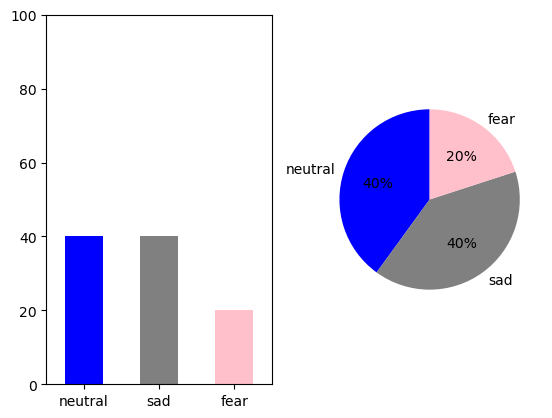

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_0.mp3


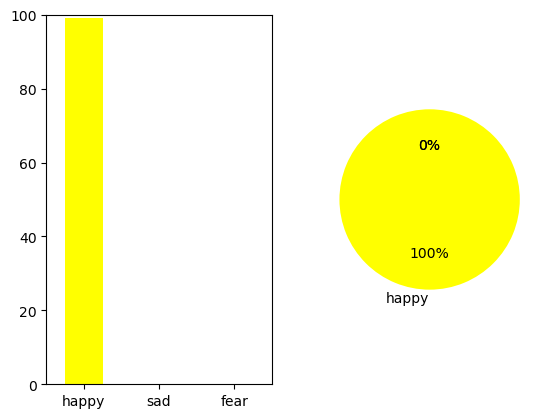

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_1.mp4


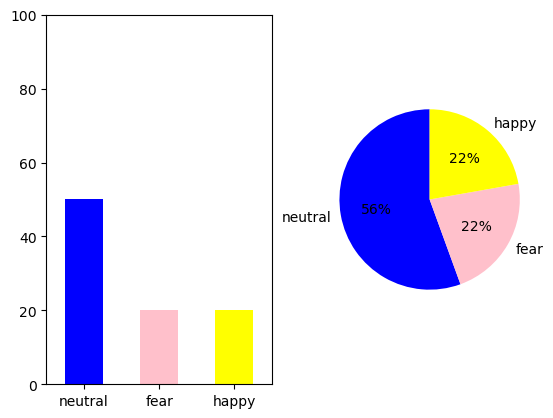

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_1.mp3


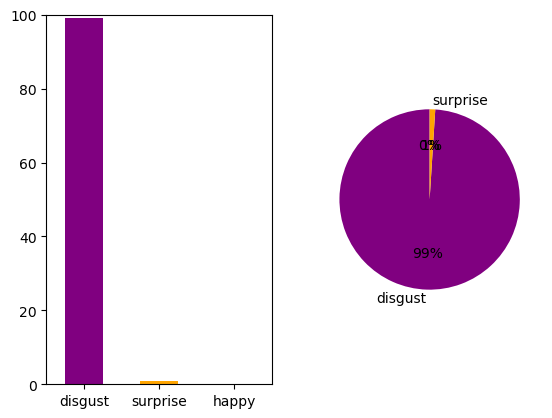

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_0.mp4


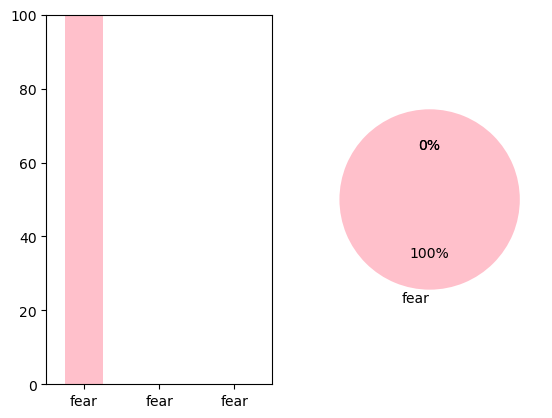

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_0.mp3


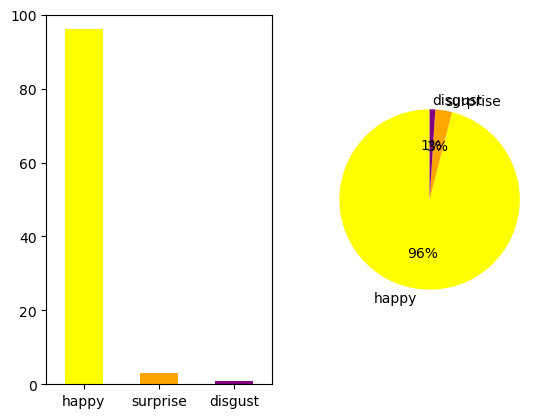

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_2.mp4


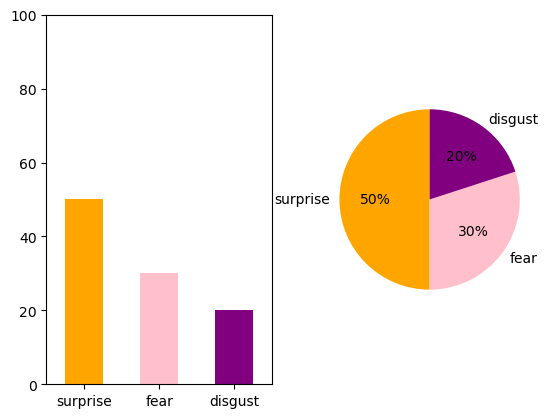

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_2.mp3


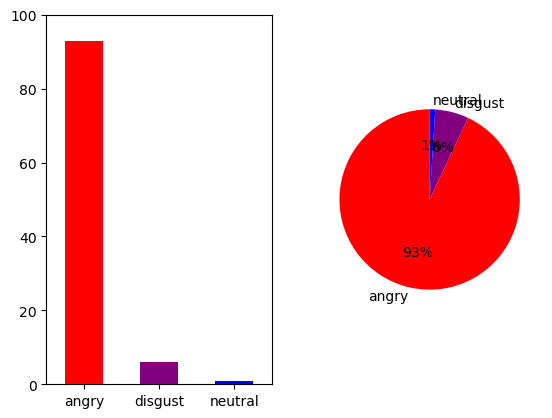

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_3.mp4


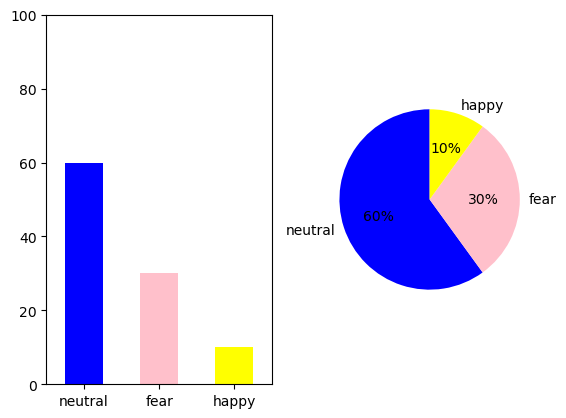

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_3.mp3


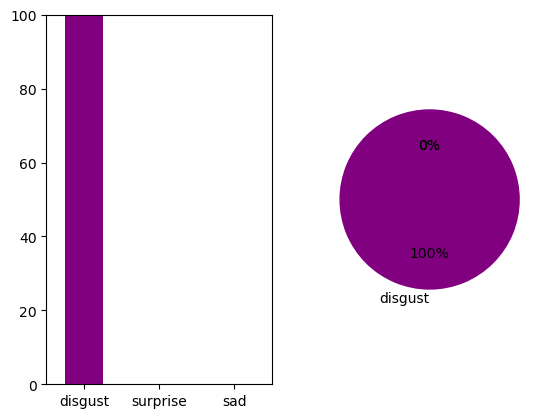

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_1.mp4


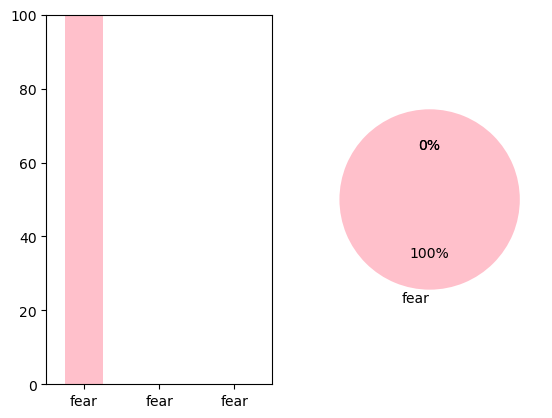

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_1.mp3


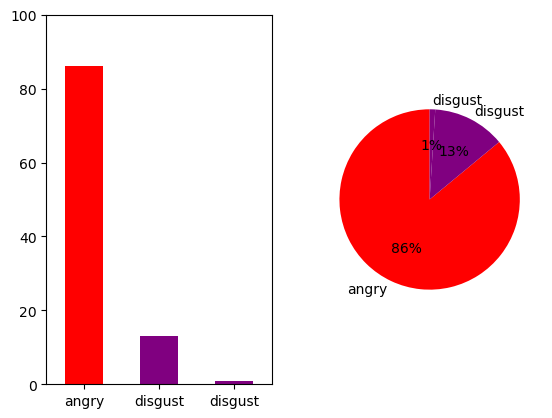

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_4.mp4


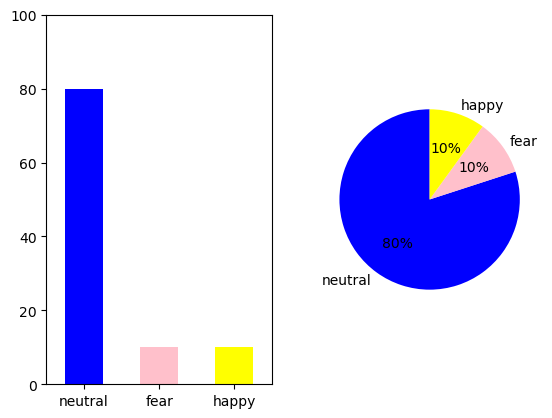

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_4.mp3


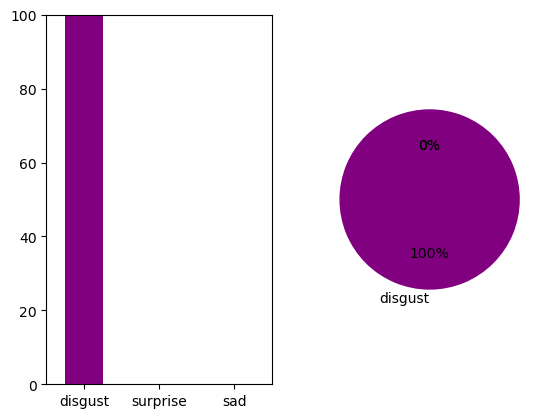

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_2.mp4


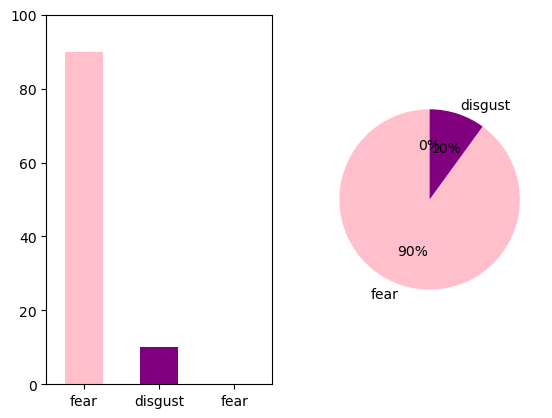

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_2.mp3


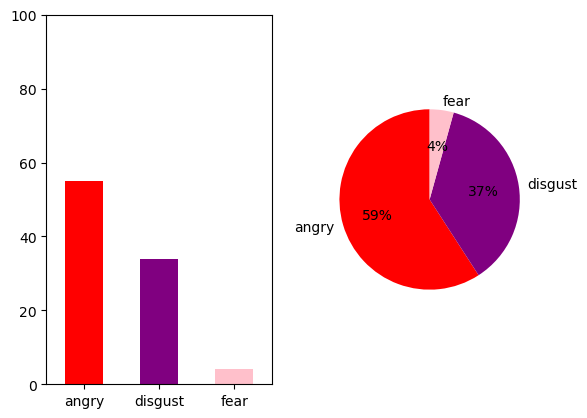

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_5.mp4


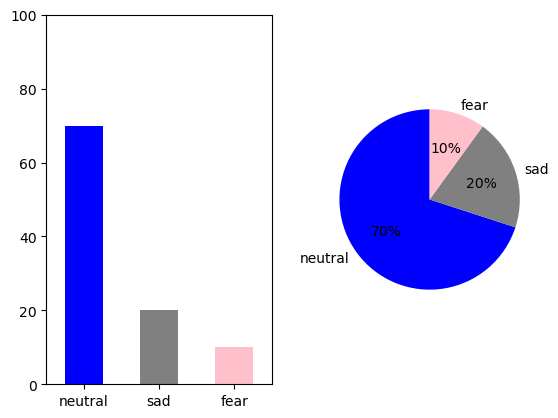

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_5.mp3


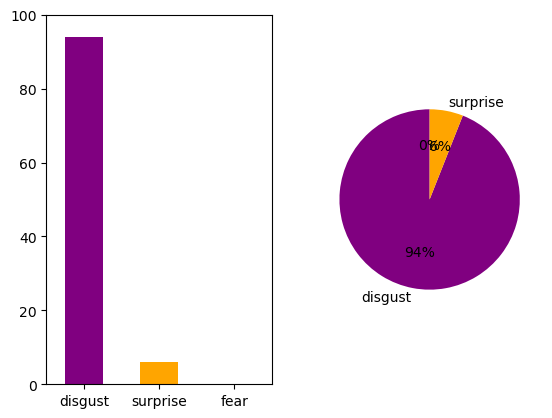

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_3.mp4


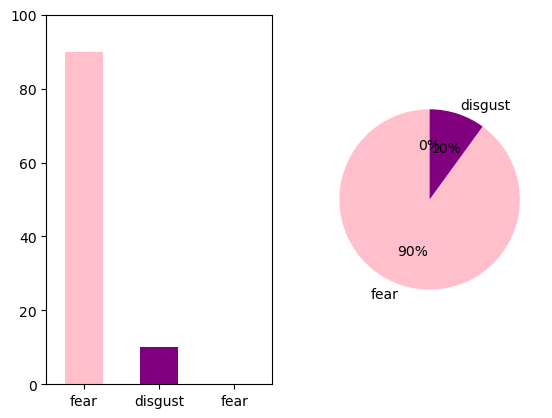

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_3.mp3


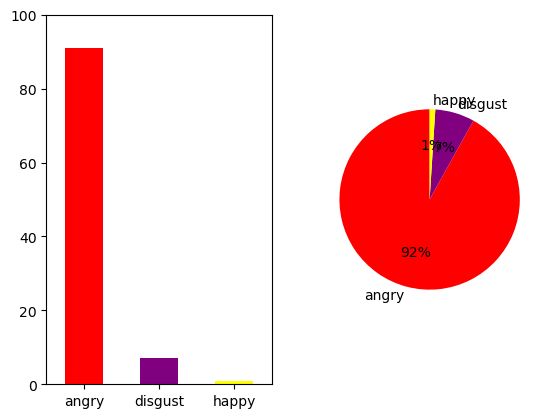

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_6.mp4


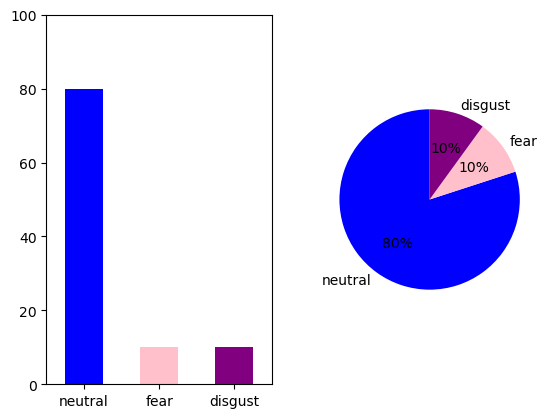

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_6.mp3


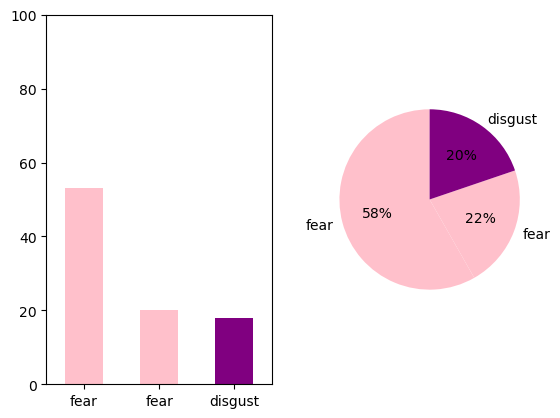

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_4.mp4


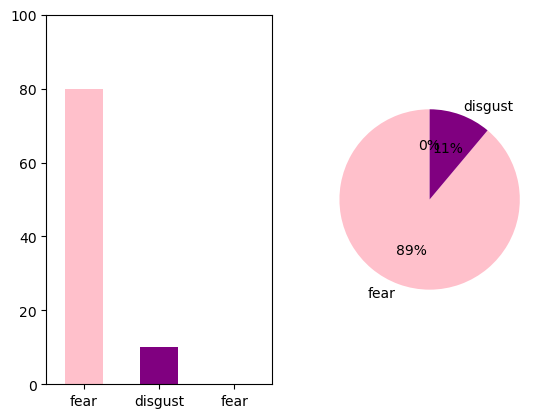

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_4.mp3


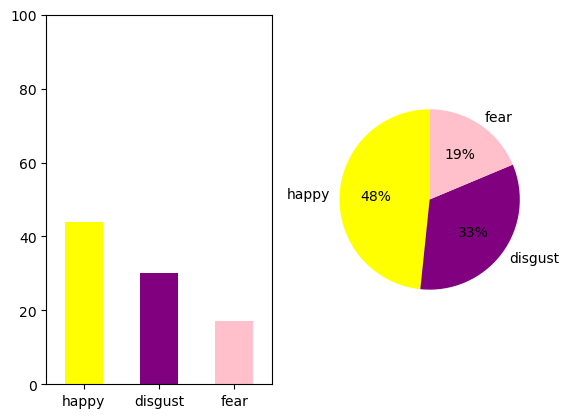

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_7.mp4


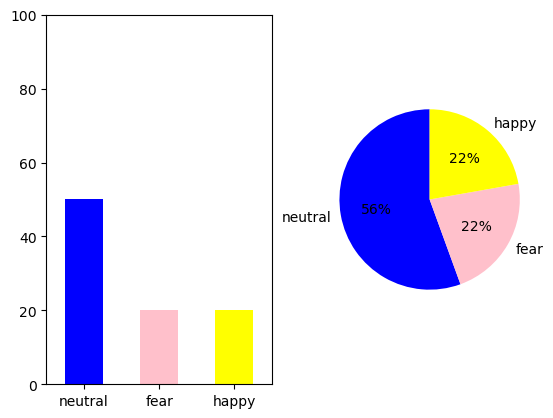

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_7.mp3


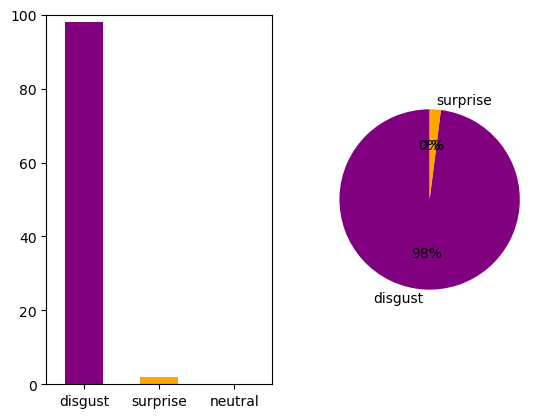

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_8.mp4


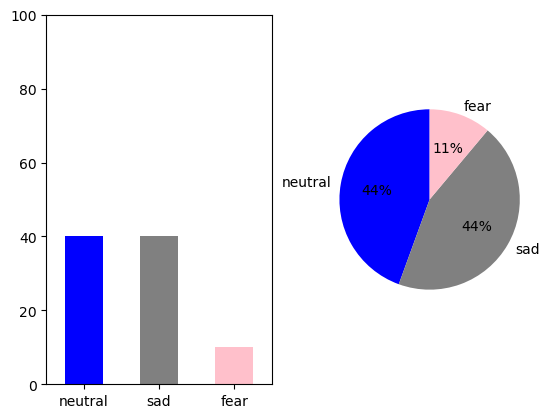

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_8.mp3


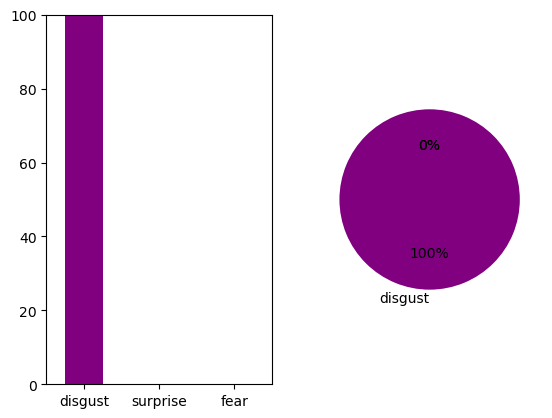

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_5.mp4


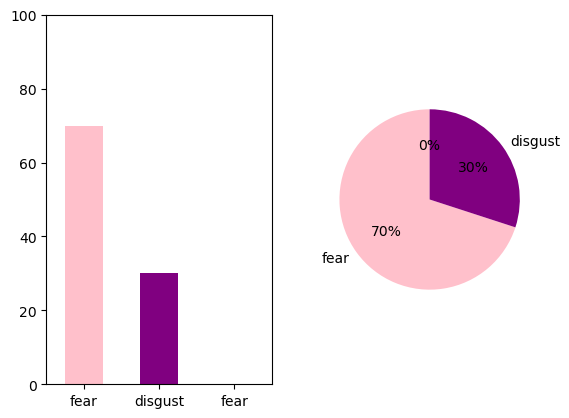

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_5.mp3


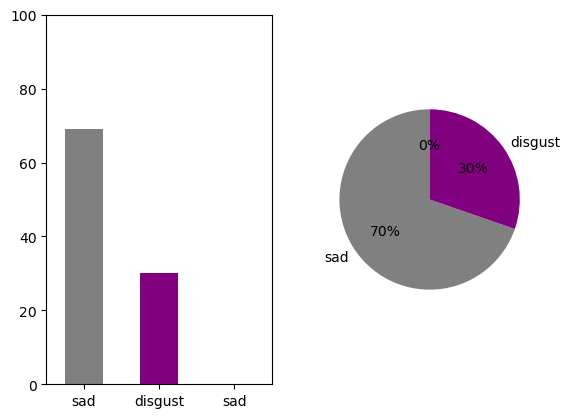

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_9.mp4


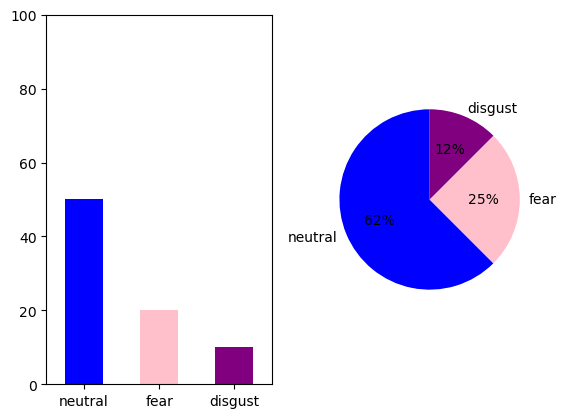

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_9.mp3


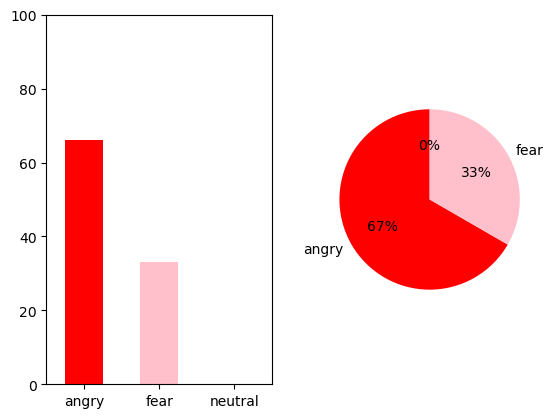

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_6.mp4


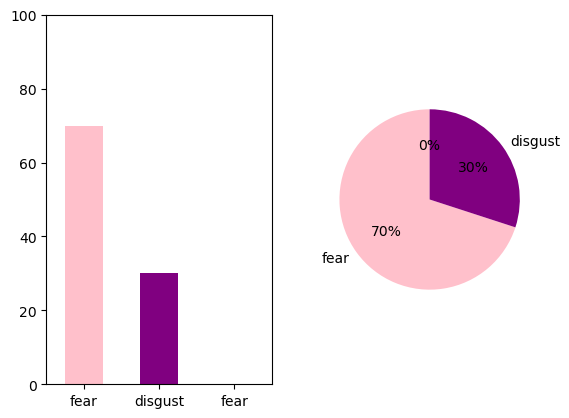

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_6.mp3


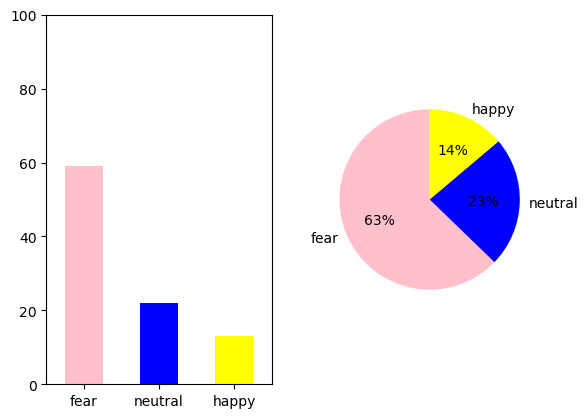

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_7.mp4


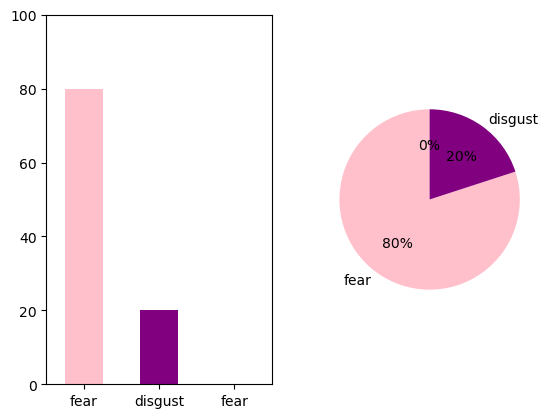

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_7.mp3


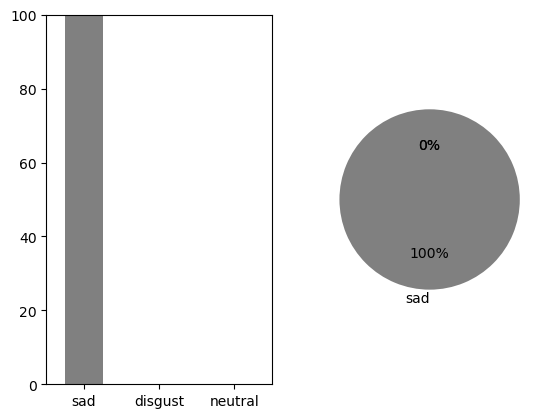

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_10.mp4


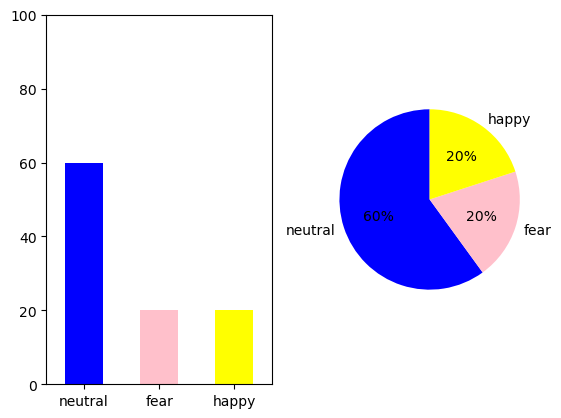

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_10.mp3


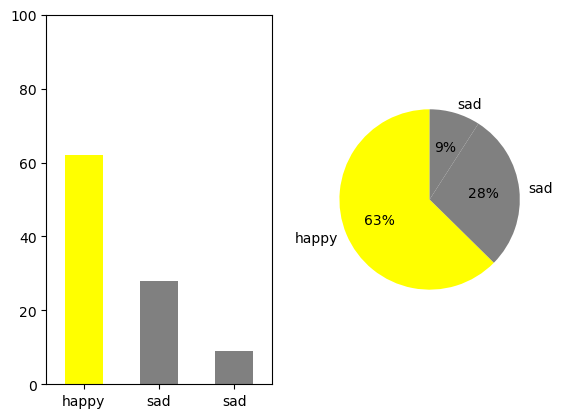

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_8.mp4


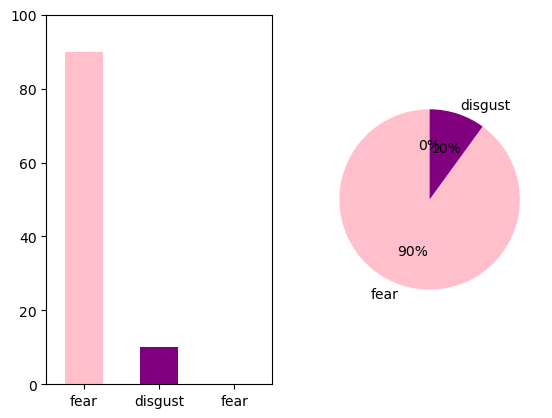

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_8.mp3


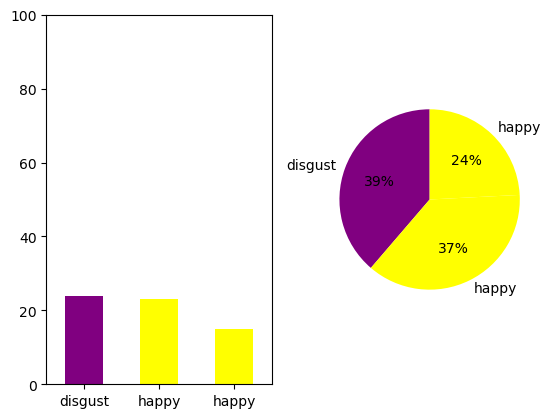

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_11.mp4


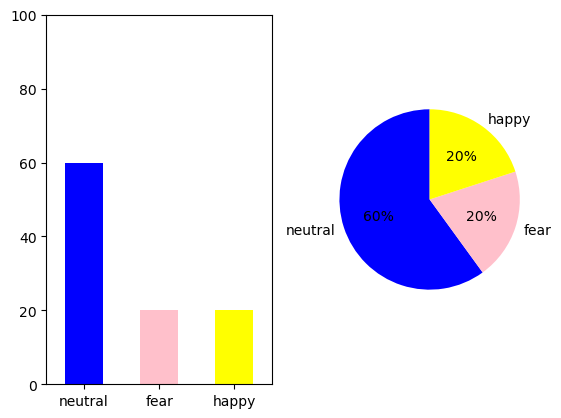

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_11.mp3


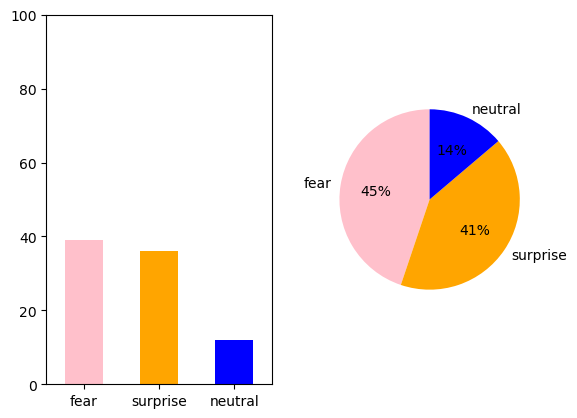

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_12.mp4


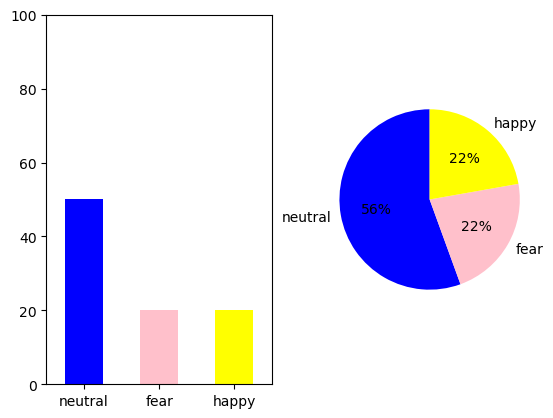

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_12.mp3


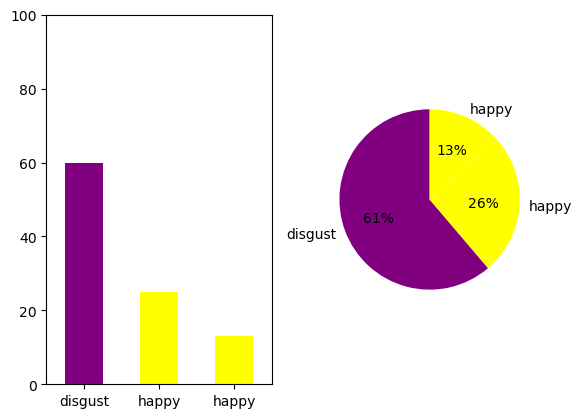

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_9.mp4


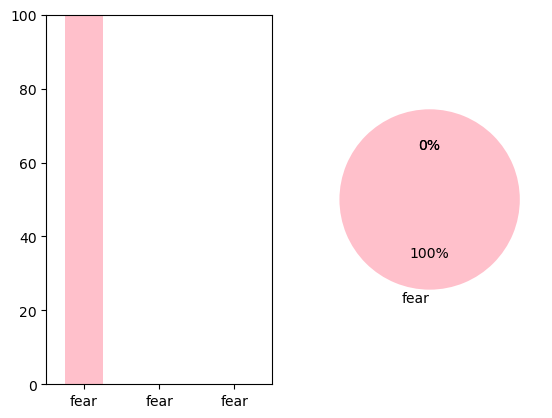

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_9.mp3


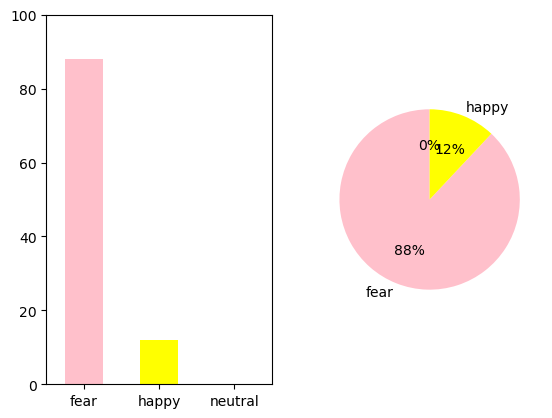

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_13.mp4


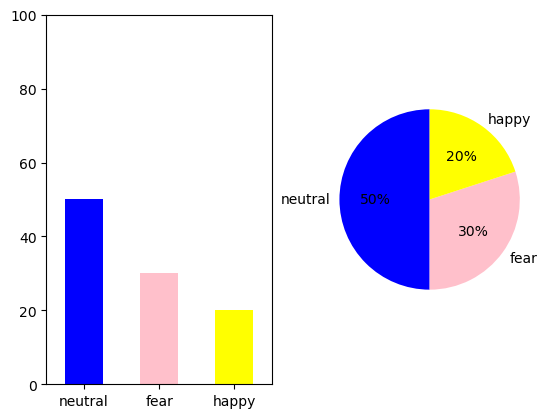

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_13.mp3


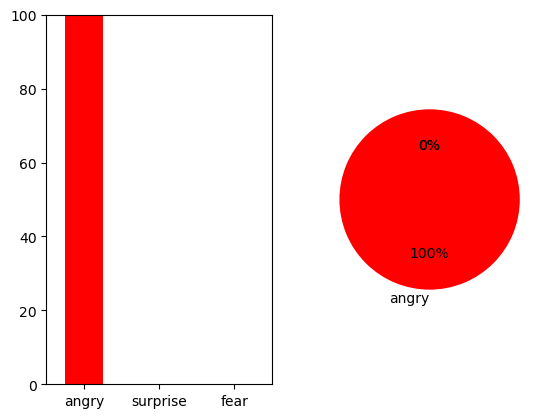

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_14.mp4


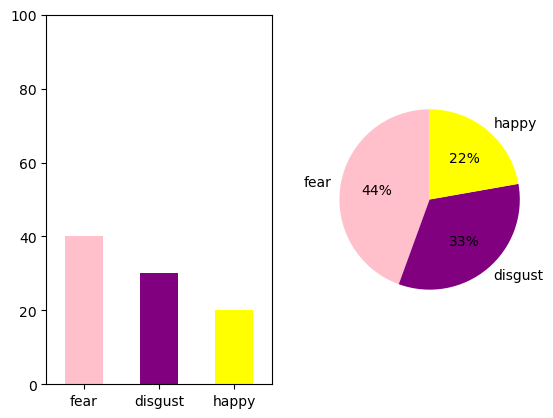

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_14.mp3


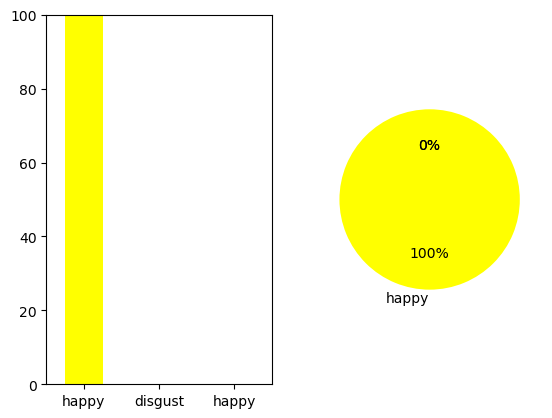

In [448]:
import glob, os
# get list of video files in order
video_list = sorted(glob.glob("/home/chris/reesby/python/test_interviews/interview_1/spk*.mp4"),key=os.path.getmtime)
# get list of audio files in order
audio_list = sorted(glob.glob("/home/chris/reesby/python/test_interviews/interview_1/spk*.mp3"),key=os.path.getmtime)
#print(zip(video_list,audio_list))

# combine the video and audio file together using zip 
for vid_file, aud_file in zip(video_list,audio_list):
    print("Video Emotions\n"+vid_file)
    get_Video_emotions(vid_file)
    print("Audio Emotions\n"+aud_file)
    get_Audio_emotions(aud_file)

    

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_0.mp4


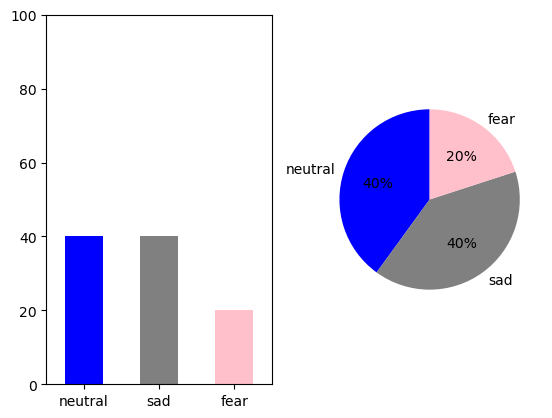

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_0.mp3


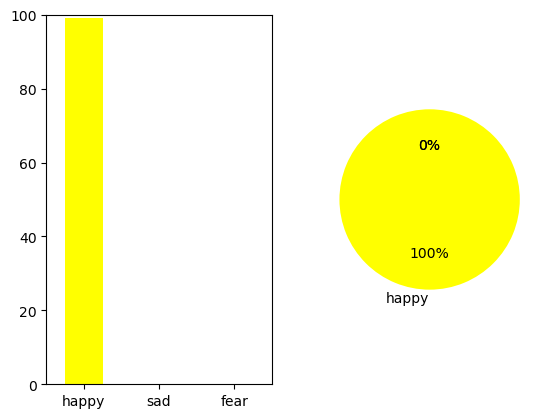

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_1.mp4


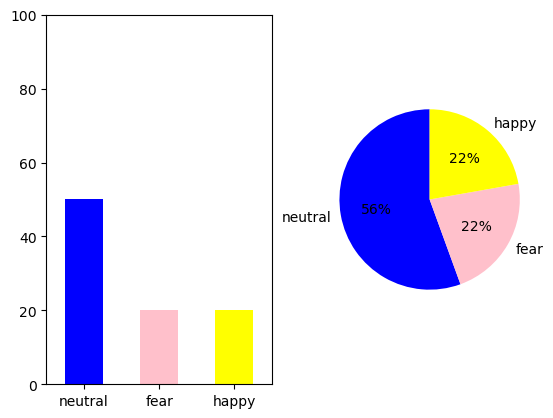

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_1.mp3


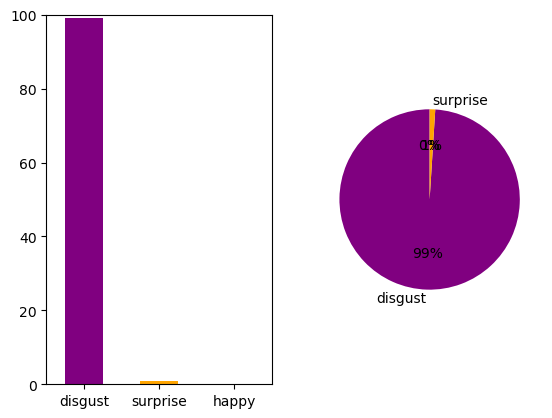

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_0.mp4


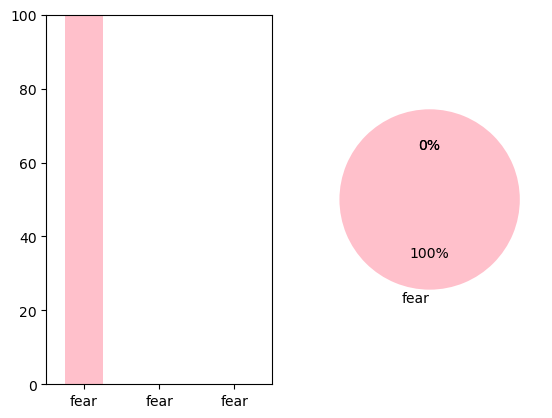

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_0.mp3


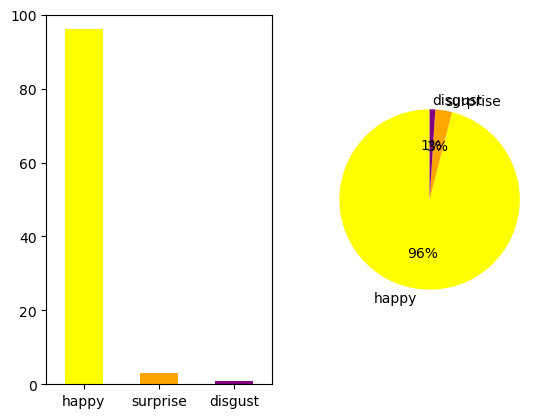

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_2.mp4


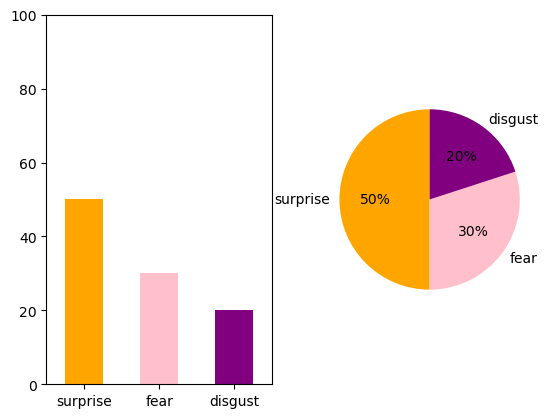

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_2.mp3


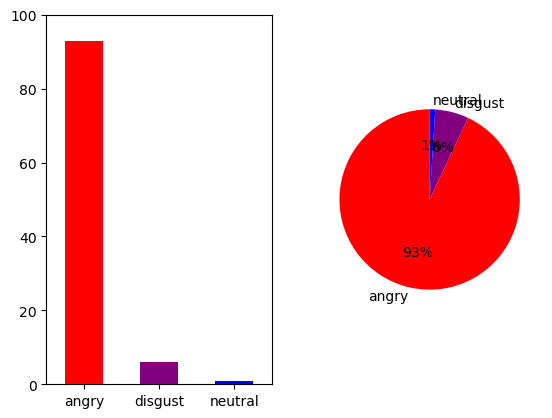

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_3.mp4


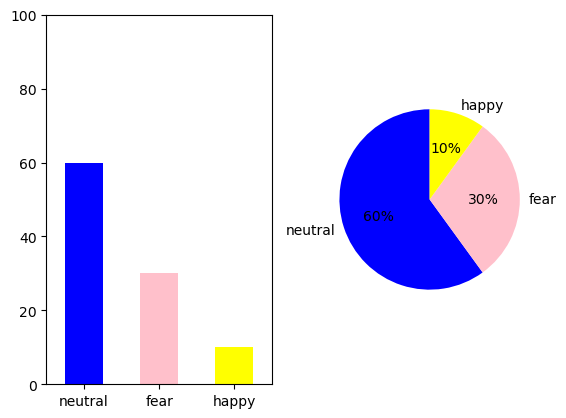

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_3.mp3


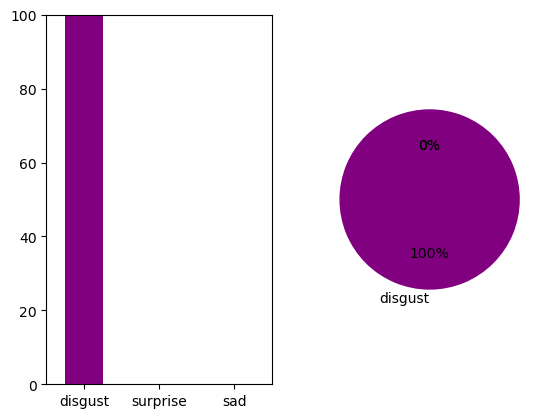

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_1.mp4


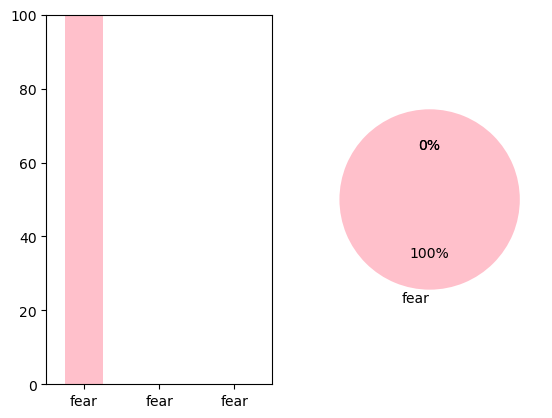

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_1.mp3


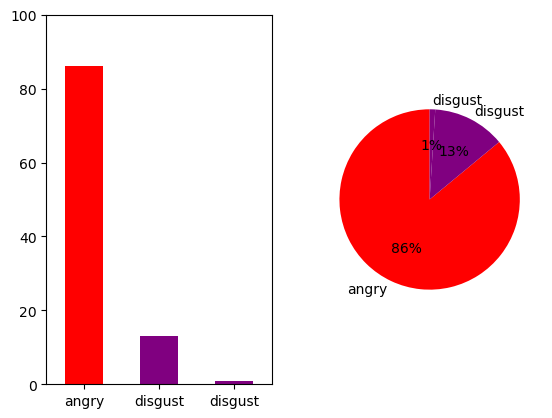

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_4.mp4


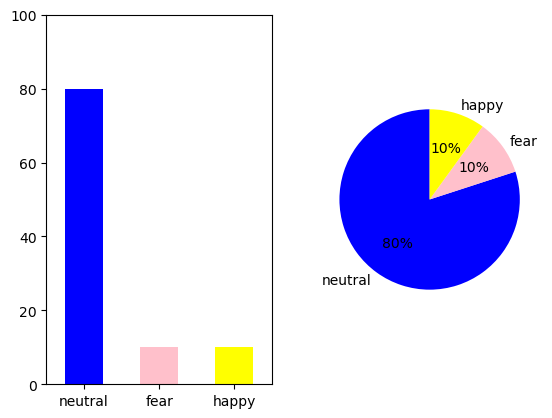

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_4.mp3


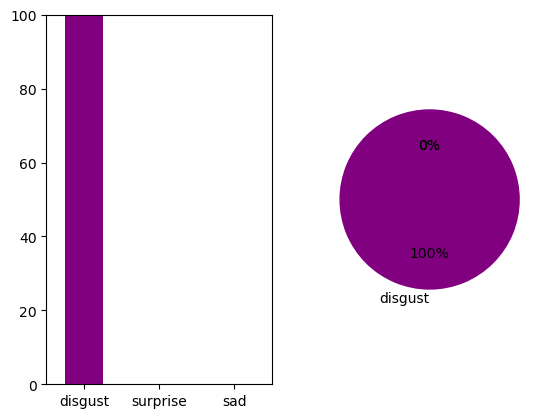

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_2.mp4


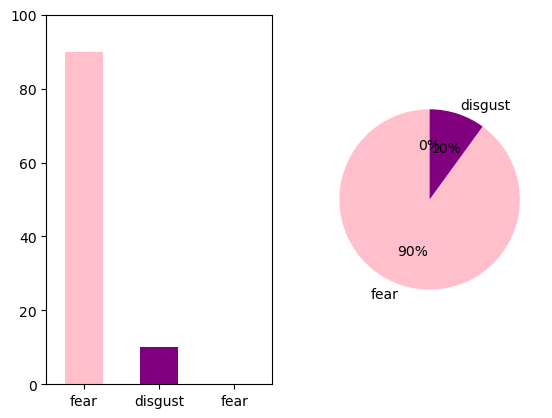

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_2.mp3


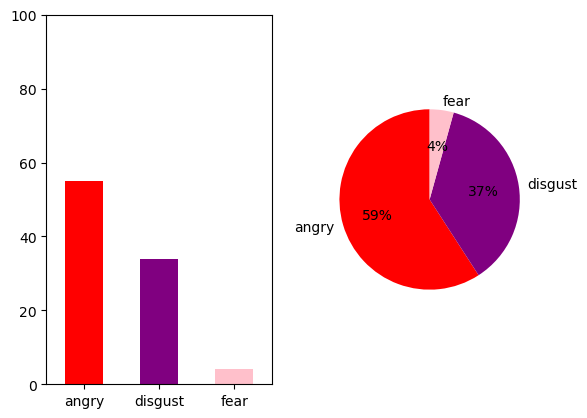

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_5.mp4


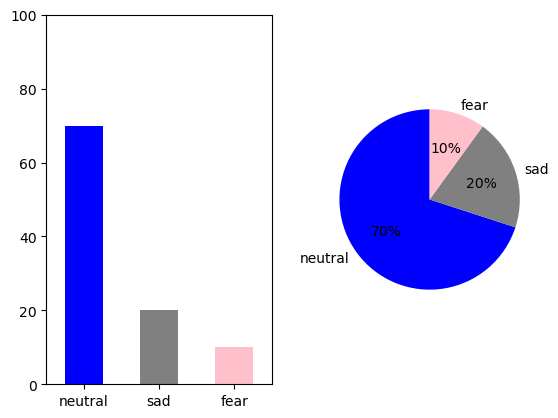

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_5.mp3


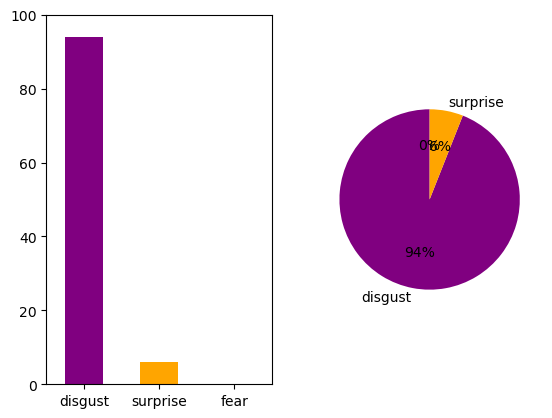

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_3.mp4


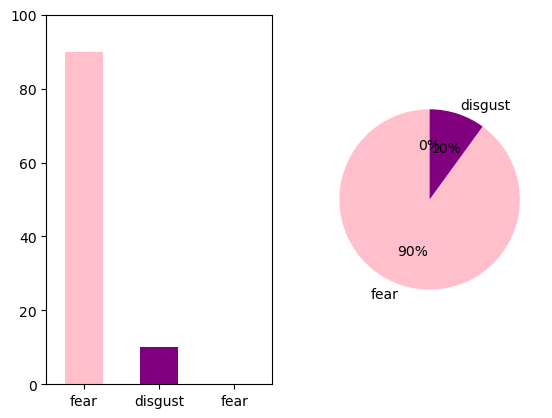

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_3.mp3


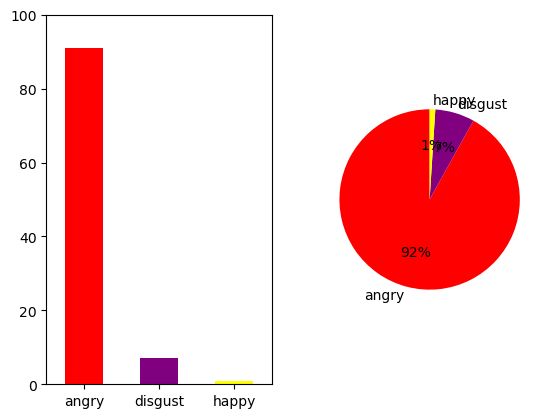

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_6.mp4


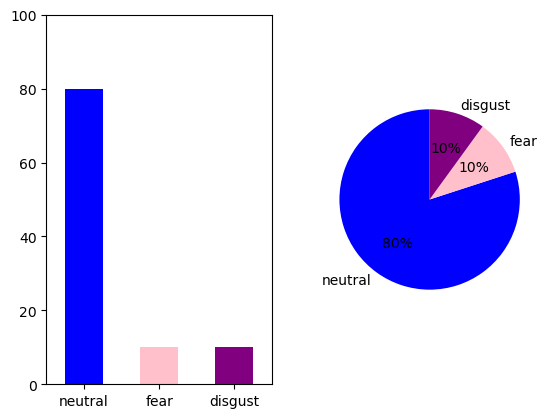

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_6.mp3


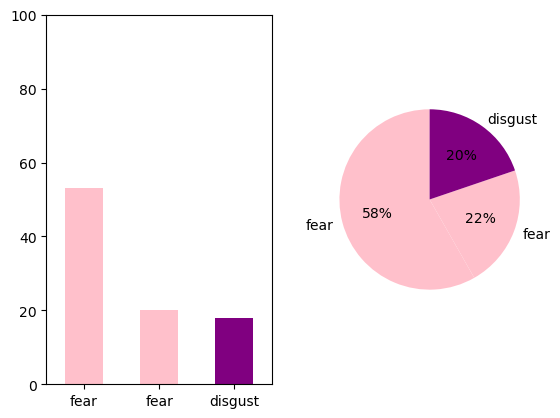

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_4.mp4


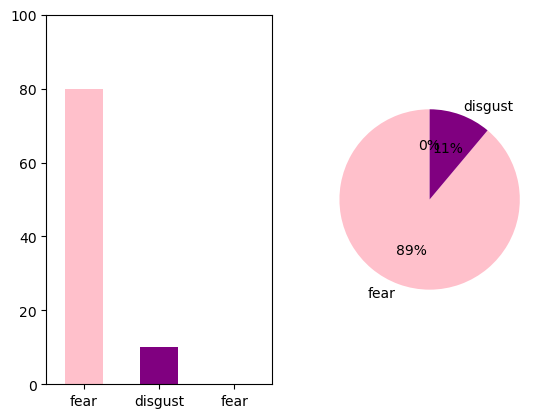

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_4.mp3


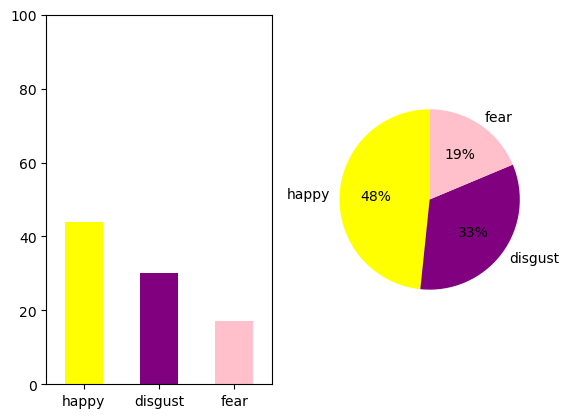

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_7.mp4


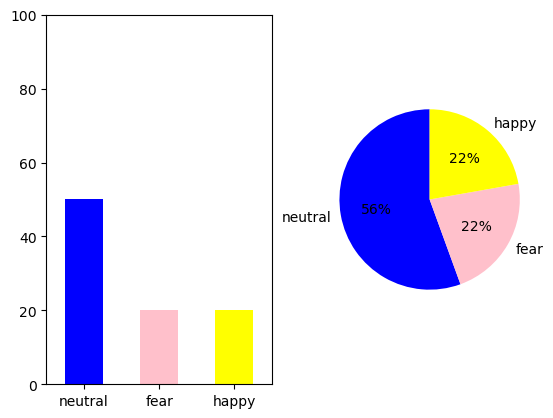

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_7.mp3


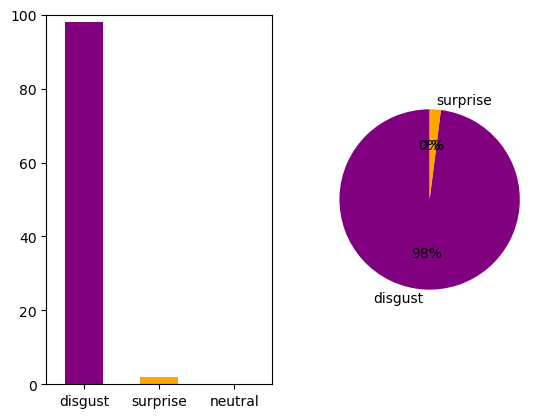

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_8.mp4


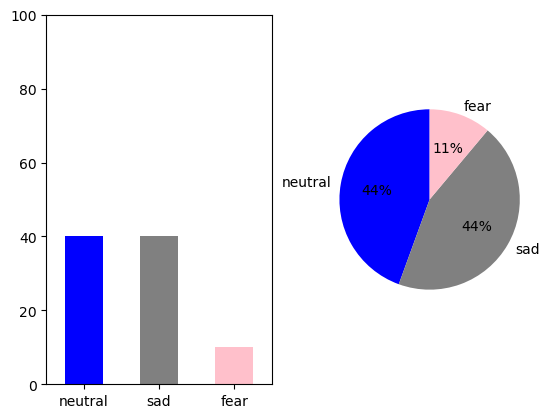

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_8.mp3


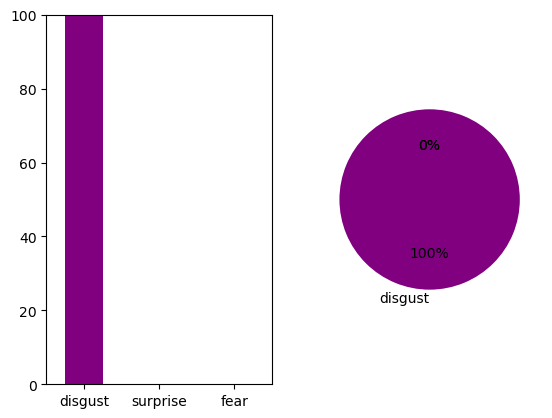

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_5.mp4


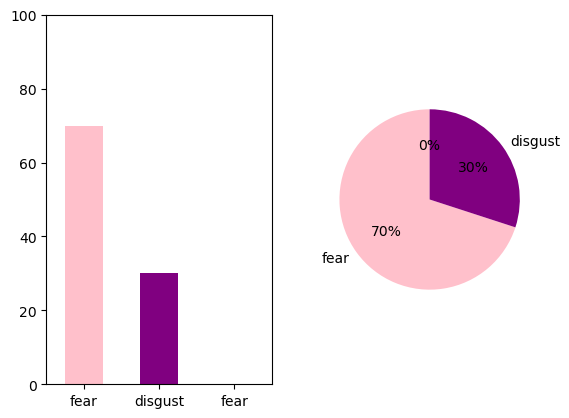

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_5.mp3


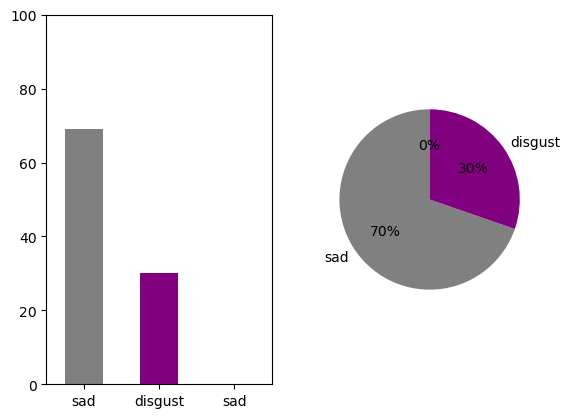

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_9.mp4


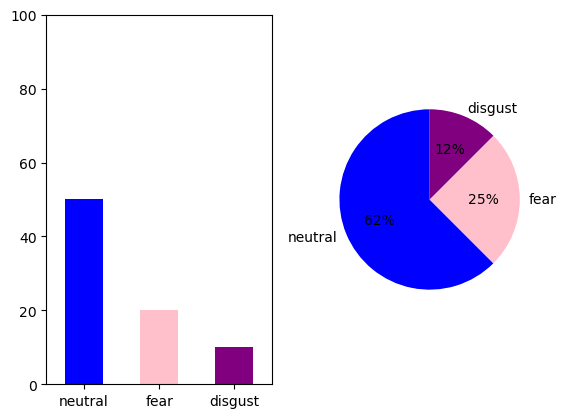

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_9.mp3


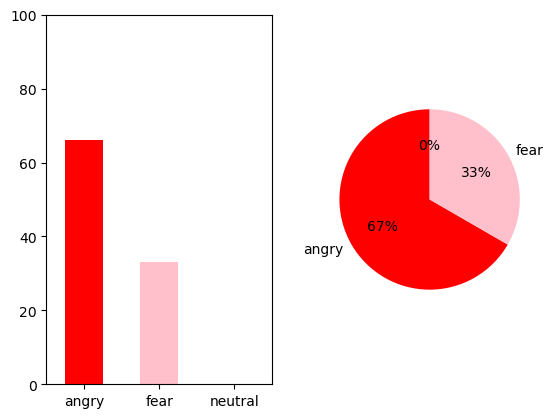

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_6.mp4


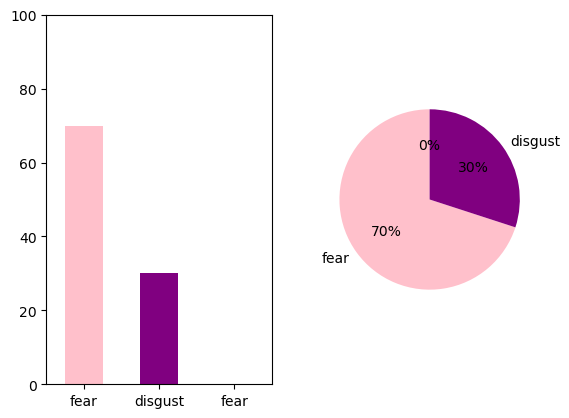

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_6.mp3


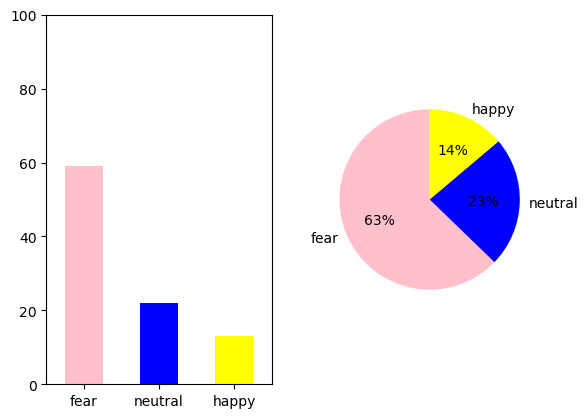

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_7.mp4


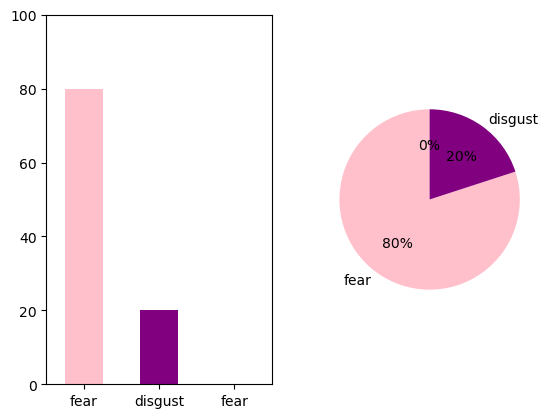

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_7.mp3


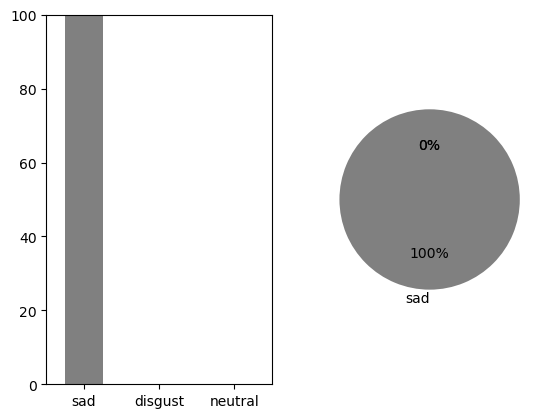

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_10.mp4


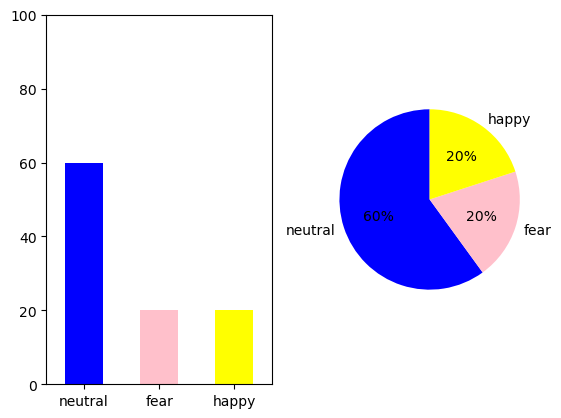

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_10.mp3


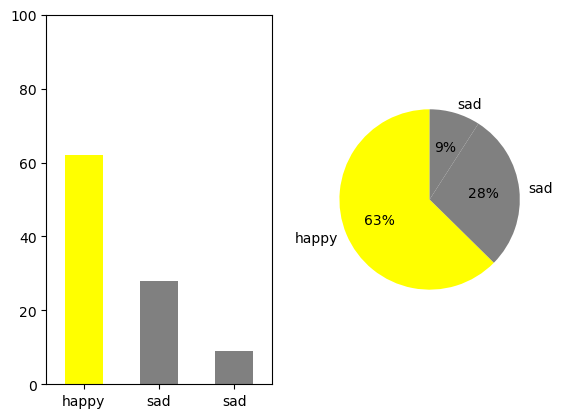

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_8.mp4


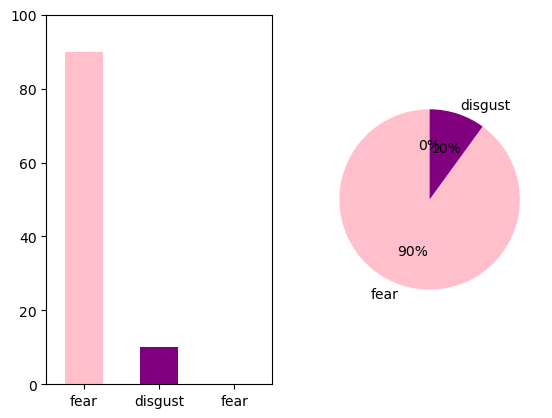

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_8.mp3


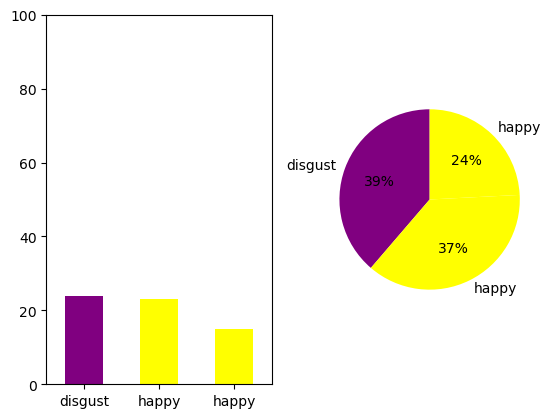

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_11.mp4


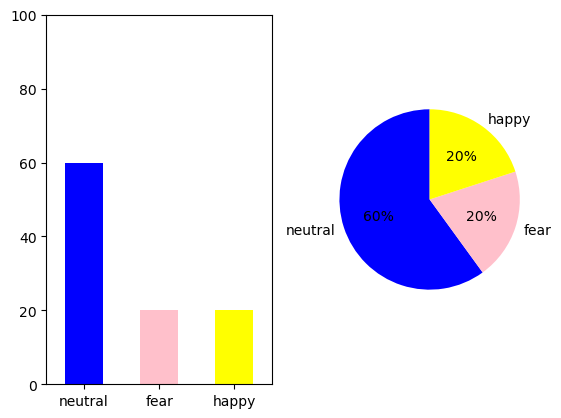

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_11.mp3


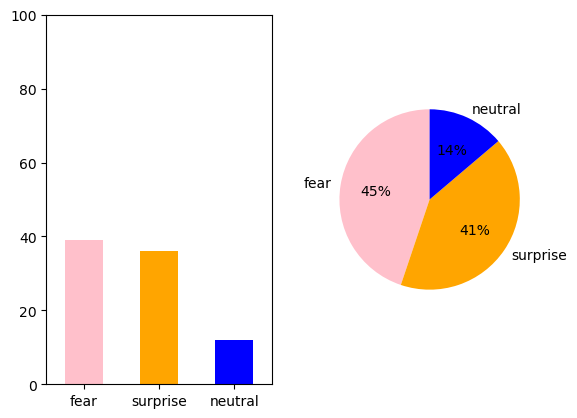

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_12.mp4


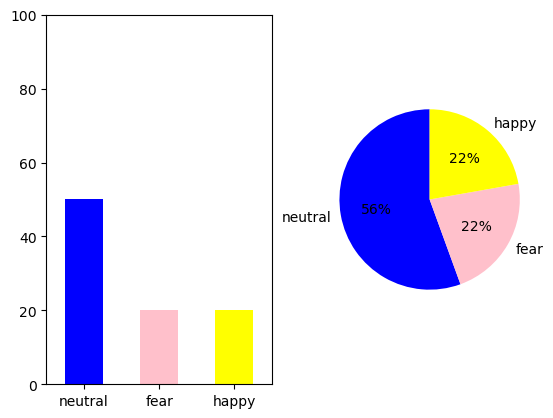

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_12.mp3


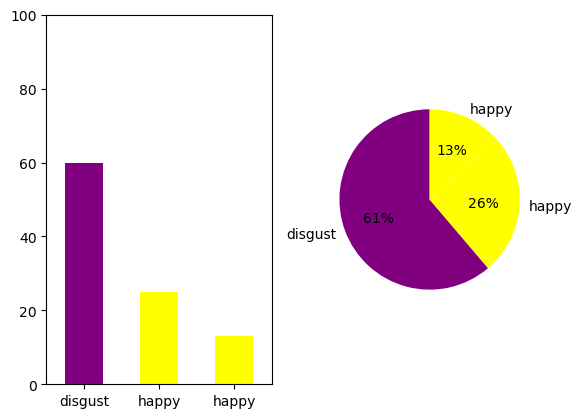

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_9.mp4


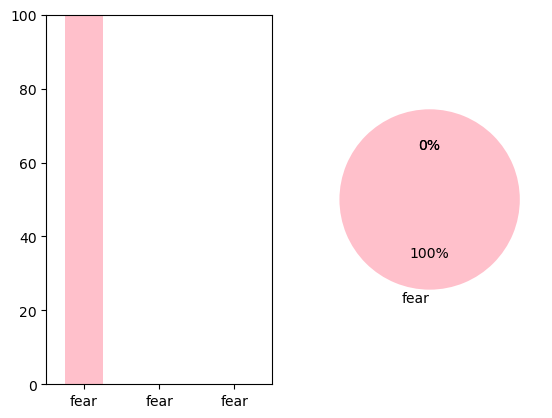

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_1_9.mp3


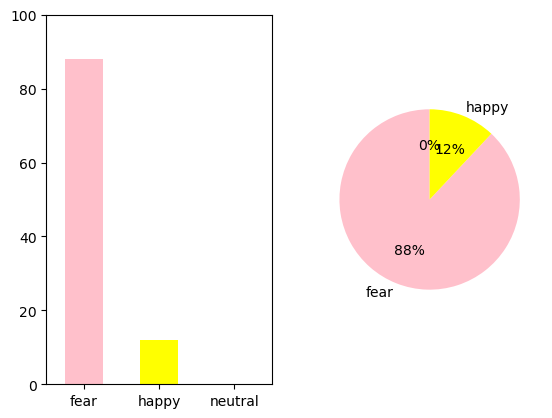

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_13.mp4


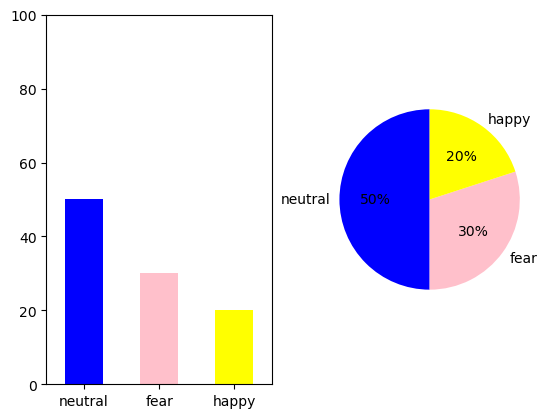

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_13.mp3


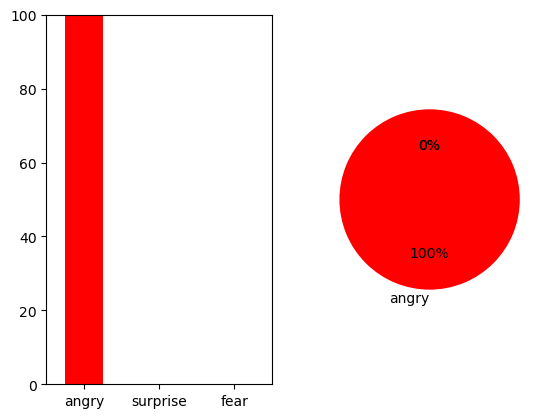

Video Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_14.mp4


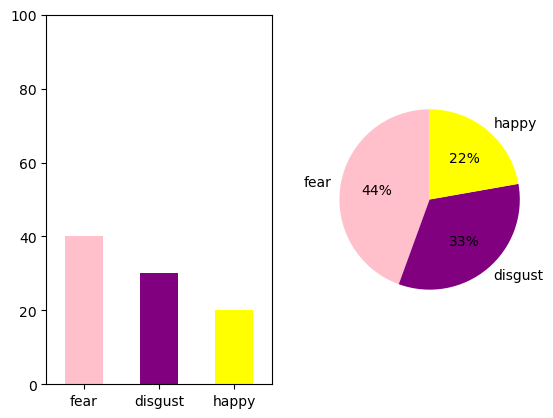

Audio Emotions
/home/chris/reesby/python/test_interviews/interview_1/spk_0_14.mp3


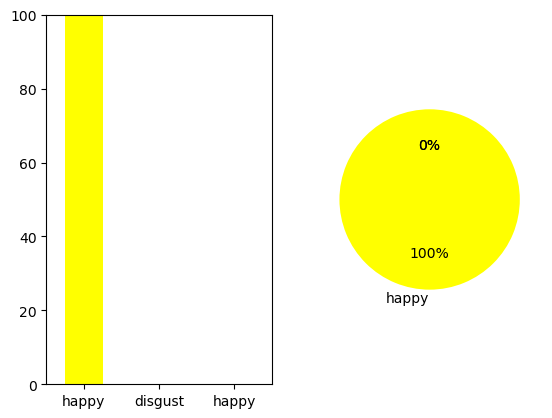

In [413]:
import glob, os
# get list of video files in order
video_list = sorted(glob.glob("/home/chris/reesby/python/test_interviews/interview_1/spk*.mp4"),key=os.path.getmtime)
# get list of audio files in order
audio_list = sorted(glob.glob("/home/chris/reesby/python/test_interviews/interview_1/spk*.mp3"),key=os.path.getmtime)
#print(zip(video_list,audio_list))

# combine the video and audio file together using zip 
for vid_file, aud_file in zip(video_list,audio_list):
    print("Video Emotions\n"+vid_file)
    get_Video_emotions(vid_file)
    print("Audio Emotions\n"+aud_file)
    get_Audio_emotions(aud_file)

    

In [452]:
import os
import img2pdf

path = '/home/chris/reesby/python/test_interviews/interview_1/'
os.chdir(path)
images = [i for i in sorted(os.listdir(os.getcwd()),key=os.path.getmtime) if i.endswith(".jpg")]

with open("all_graphs.pdf", "wb") as f:
    f.write(img2pdf.convert(images))

In [119]:
# simple way to recombine the videos

clip1 = VideoFileClip("spk_1_10.mp4")
clip2 = VideoFileClip("spk_1_11.mp4")


final_combined = concatenate_videoclips([clip1,clip2])
final_combined.write_videofile("combined.mp4")

t:   9%|▊         | 56/652 [00:00<00:01, 557.70it/s, now=None]

Moviepy - Building video combined.mp4.
Moviepy - Writing video combined.mp4




chunk:  56%|█████▌    | 29/52 [17:37:19<13:58:34, 2187.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready combined.mp4
